[INFO] Processing 1e-5 (Conservative)...
[INFO] Processing 5e-5 (Baseline)...
[INFO] Processing 1e-4 (Aggressive)...
[INFO] Data loaded. Total training rows: 1800


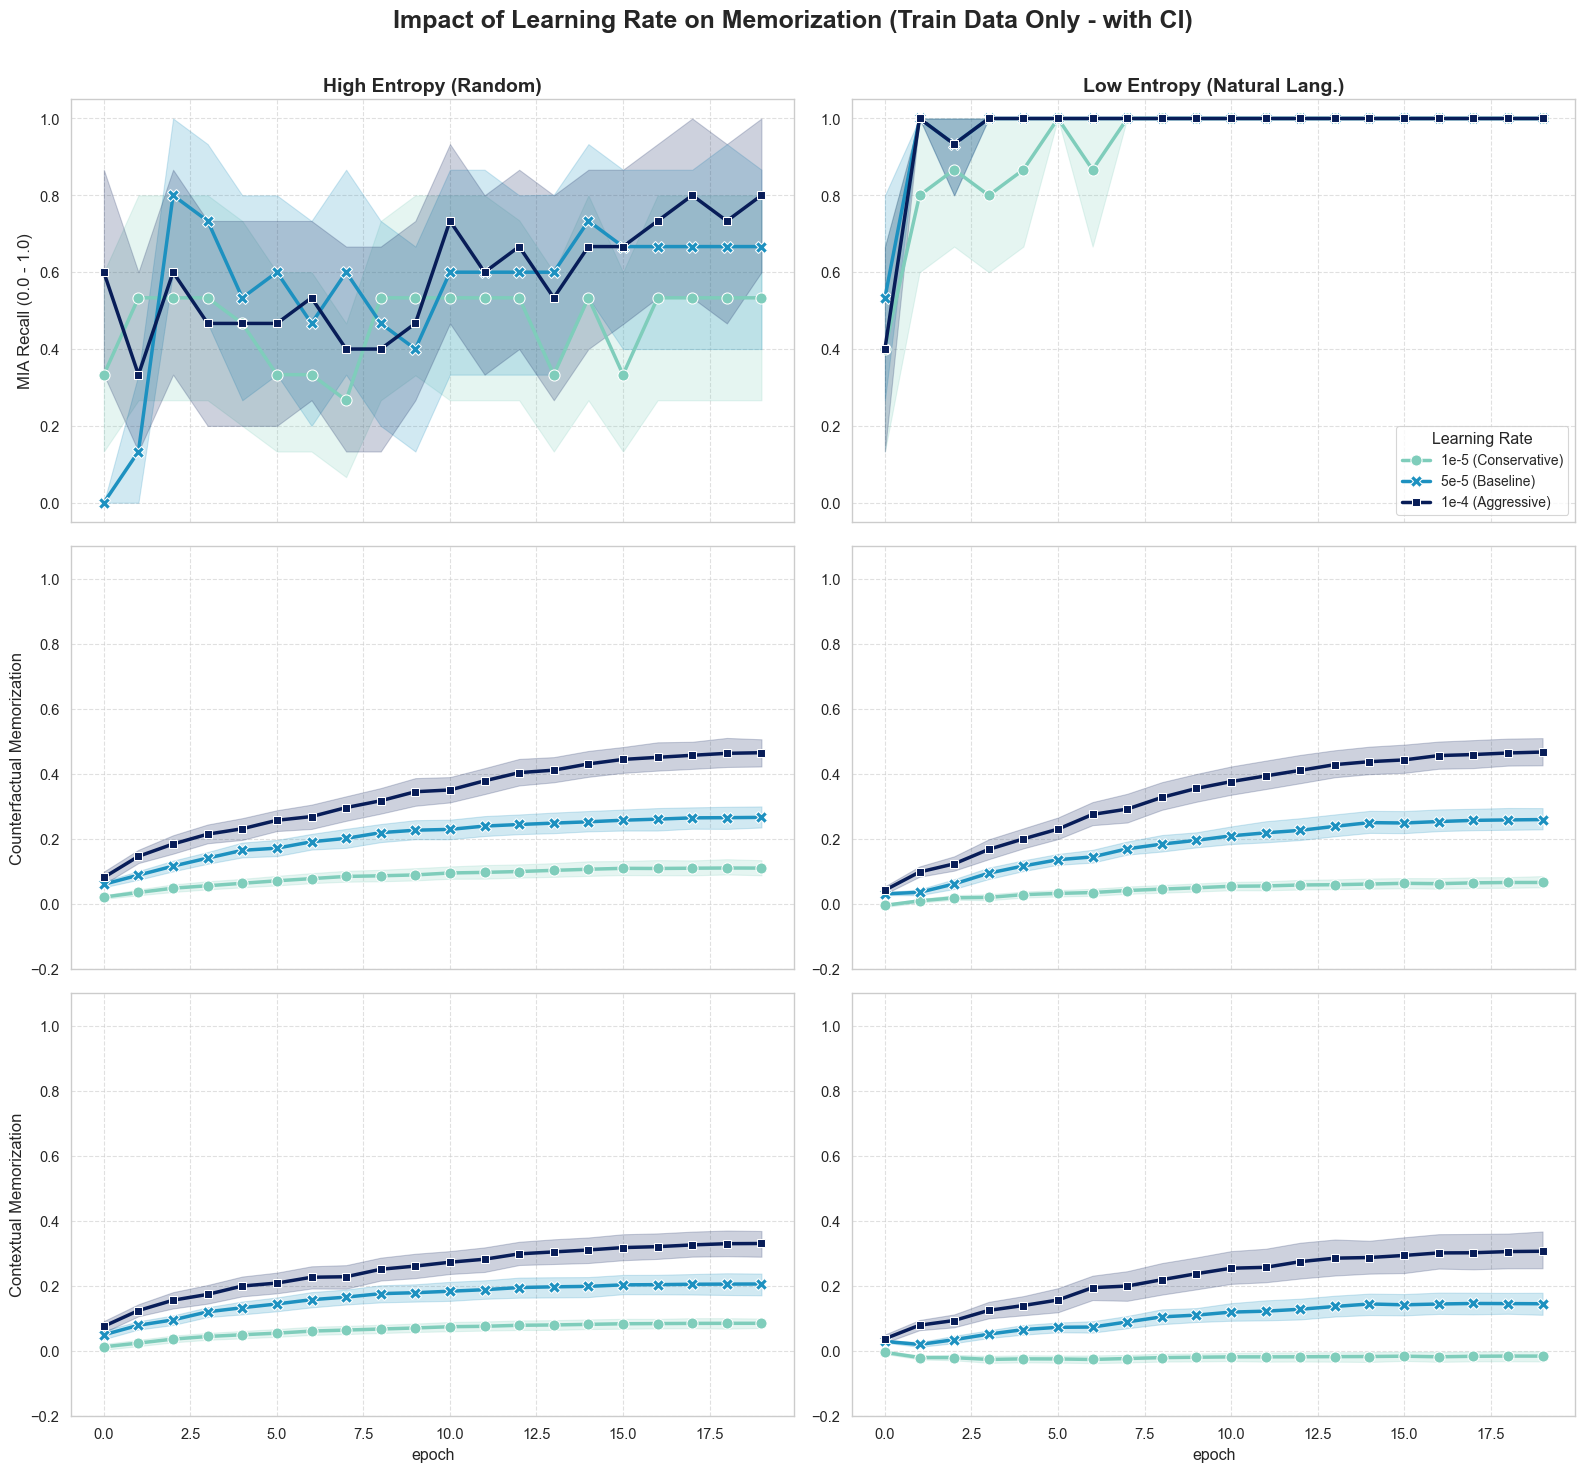

Saved as 'gpt2_lr_comparison_ci.png'


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# ==============================================================================
# 1. FILE CONFIGURATION
# ==============================================================================
file_paths = {
    "1e-5 (Conservative)": "wikipedia/experiments/run_20251211_175952/results/canary_details_full.csv",
    "5e-5 (Baseline)":     "wikipedia/experiments/run_20251203_134201/results/canary_details_full.csv",
    "1e-4 (Aggressive)":   "wikipedia/experiments/run_20251212_095946/results/canary_details_full.csv"
}

# ==============================================================================
# 2. HELPER: CALCULATE MIA RECALL (0-1)
# ==============================================================================
def calculate_recall_and_filter(df):
    """
    1. Calculates MIA threshold based on Validation data (10% FPR).
    2. Converts raw scores to 0 (Not Memorized) or 1 (Memorized).
    3. Returns ONLY Training rows.
    """
    df = df.copy()
    df['is_memorized'] = 0 
    
    # Determine Entropy Type if missing
    if 'Entropy Type' not in df.columns:
         df['Entropy Type'] = df['canary_id'].apply(
            lambda x: 'High Entropy (Random)' if str(x).startswith('he_') else 'Low Entropy (Natural Lang.)'
        )

    # Iterate through each Epoch and Entropy Type combination
    for epoch in df['epoch'].unique():
        for ent_type in df['Entropy Type'].unique():
            # Mask to isolate current group
            subset_mask = (df['epoch'] == epoch) & (df['Entropy Type'] == ent_type)
            
            # Get VALIDATION scores to calculate threshold
            val_scores = df.loc[subset_mask & (df['split'] == 'validation'), 'mia_score']
            
            if len(val_scores) > 0:
                # Threshold at 90th percentile (10% False Positive Rate)
                threshold = np.percentile(val_scores, 90)
                
                # Apply threshold to TRAINING data
                train_mask = subset_mask & (df['split'] == 'train')
                df.loc[train_mask, 'is_memorized'] = (df.loc[train_mask, 'mia_score'] > threshold).astype(int)
    
    # Return Training Set only
    return df[df['split'] == 'train'].copy()

# ==============================================================================
# 3. DATA LOADING & PROCESSING
# ==============================================================================
df_list = []

for label, path in file_paths.items():
    if os.path.exists(path):
        print(f"[INFO] Processing {label}...")
        tmp_df = pd.read_csv(path)
        tmp_df['Learning Rate'] = label
        
        # Calculate Recall and Filter Train Data
        tmp_processed = calculate_recall_and_filter(tmp_df)
        
        df_list.append(tmp_processed)
    else:
        print(f"[WARNING] File not found: {path}")

if df_list:
    full_df = pd.concat(df_list, ignore_index=True)
    print(f"[INFO] Data loaded. Total training rows: {len(full_df)}")
    
    # --- CRITICAL CHANGE ---
    # We DO NOT groupby/mean here. We pass the full dataset to seaborn
    # so it can calculate confidence intervals automatically.
else:
    print("[ERROR] No data loaded.")
    full_df = pd.DataFrame()

# ==============================================================================
# 4. PLOTTING
# ==============================================================================
if not full_df.empty:
    sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
    custom_palette = {"1e-5 (Conservative)": "#7fcdbb", "5e-5 (Baseline)": "#1d91c0", "1e-4 (Aggressive)": "#081d58"}

    fig, axes = plt.subplots(3, 2, figsize=(16, 15), sharex=True)

    metrics_config = [
        ('is_memorized', 'MIA Recall (0.0 - 1.0)'),
        ('counterfactual_score', 'Counterfactual Memorization'),
        ('contextual_score', 'Contextual Memorization')
    ]

    for i, (metric_col, metric_title) in enumerate(metrics_config):
        for j, entropy_type in enumerate(['High Entropy (Random)', 'Low Entropy (Natural Lang.)']):
            
            ax = axes[i, j]
            
            # Using full_df directly allows Seaborn to compute CI (95% by default)
            sns.lineplot(
                data=full_df[full_df['Entropy Type'] == entropy_type],
                x='epoch', 
                y=metric_col, 
                hue='Learning Rate', 
                style='Learning Rate',
                markers=True, 
                dashes=False, 
                palette=custom_palette, 
                ax=ax,
                linewidth=2.5, 
                markersize=8,
                errorbar=('ci', 95),      # <--- Shows 95% Confidence Interval
                err_kws={'alpha': 0.2}    # <--- Transparency for the bands
            )
            
            # Titles and Labels
            if i == 0: ax.set_title(f"{entropy_type}", fontsize=14, fontweight='bold')
            if j == 0: ax.set_ylabel(metric_title, fontsize=12)
            else: ax.set_ylabel("")
            
            # Axis Limits
            if metric_col == 'is_memorized':
                ax.set_ylim(-0.05, 1.05) 
            else:
                ax.set_ylim(-0.2, 1.1)   
                
            ax.grid(True, linestyle='--', alpha=0.6)
            
            # Legend placement
            if i == 0 and j == 1:
                ax.legend(title="Learning Rate", loc='lower right', fontsize=10)
            else:
                if ax.get_legend(): ax.get_legend().remove()

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.suptitle(f"Impact of Learning Rate on Memorization (Train Data Only - with CI)", fontsize=18, fontweight='bold')

    plt.show()
    fig.savefig("gpt2_lr_comparison_ci.png", dpi=300, bbox_inches='tight')
    print("Saved as 'gpt2_lr_comparison_ci.png'")